In [ ]:

cheapest_history: list[tuple[list[int],list[tuple[int,int,list[int]]],int]] = []
from tsp.core.tsp import TSP
from tsp.core.solvers import pyramid_solve      # you can keep this import if you still need pyramid elsewhere
from tsp.experiment.batch_solver import solve_batch
from tsp.experiment.batch import save_problem_batch
import numpy.random as random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import json

# 1) generate & save one random TSP problem
cities = TSP.generate_random(50, w=500, h=500)
save_problem_batch([cities], 'pyramid_test/problems')

# (optional) your existing pyramid‐solve batch call
def pyramid_solve_2_4(problem):
    return pyramid_solve(problem, k=3, s=2)
solve_batch('pyramid_test/problems', pyramid_solve_2_4, 'pyramid_test/pyr_solutions')

# 2) load it back in
def load_tsp_coords(fp):
    with open(fp,'r') as f:
        return np.array(json.load(f)["cities"])

coords = load_tsp_coords("pyramid_test/problems/001.tsp")
num_cities = coords.shape[0]
print("Coords shape:", coords.shape)

tsp_problem = TSP.from_cities(coords, w=500, h=500)
centroids = [ np.array(pt, dtype=float) for pt in coords ]
full_nodes     = list(range(num_cities))
# 3) helper to compute tour length from coords
def tour_length(tour: list[int]) -> float:
    idxs   = tour + [tour[0]]
    pts    = coords[idxs]
    deltas = pts[1:] - pts[:-1]
    return np.hypot(deltas[:,0], deltas[:,1]).sum()

# 4) define & record cheapest‐insertion
history = []  

def recorded_pyramid_insertion(centroids: list[np.ndarray], full_nodes: list[int], k: int, s: int) -> list[int]:
    tour = []                # start empty, or seed with the very first city(s)
    inserted = []            # the sequence of nodes you’ve added so far

    # break full_nodes into chunks of size k
    clusters = [ full_nodes[i:i+k] 
                 for i in range(0, len(full_nodes), k) ]

    for cluster in clusters:
        # for the first cluster you might seed your tour:
        if not tour:
            tour = cluster.copy()
            inserted.extend(cluster)
            continue

        step_cands = []
        for city in cluster:
            for pos in range(len(tour)+1):
                cand = tour[:pos] + [city] + tour[pos:]
                length = tour_length(cand)   # your Euclid helper
                step_cands.append((city, pos, cand, length))

        # pick the best insertion among that cluster:
        step_cands.sort(key=lambda x: x[3])
        city,pos,tour,_ = step_cands[0]   # best one—unpack immediately

        # record just like before
        cheapest_history.append((tour.copy(), step_cands, 0))
        inserted.append(city)

        context = inserted[-s:]
    return tour


# 5) actually run it
cheapest_history.clear()
final_tour = recorded_pyramid_insertion(centroids, full_nodes, k=3, s=2)
print("Recorded steps:", len(cheapest_history))

Coords shape: (50, 2)


NameError: name 'full_nodes' is not defined

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
plt.rcParams['animation.html'] = 'jshtml'
tour_coords = coords[tour + [tour[0]]]
fig, ax = plt.subplots(figsize=(6, 6))
line, = ax.plot([], [], 'k-', lw=2)
points = ax.plot(coords[:, 0], coords[:, 1], 'ro')[0]

ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_title("Animated Pyramid Tour")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
ax.set_aspect('equal')

def init():
    line.set_data([], [])
    return line, points

def update(frame):
    x = tour_coords[:frame+1, 0]
    y = tour_coords[:frame+1, 1]
    line.set_data(x, y)
    return line, points
from IPython.display import HTML

ani = animation.FuncAnimation(
    fig, update, frames=len(tour_coords), init_func=init,
    interval=120, blit=True, repeat=False
)
HTML(ani.to_jshtml())
plt.show()
ani.save("pyramid_tour1.gif", writer="pillow", fps=10)



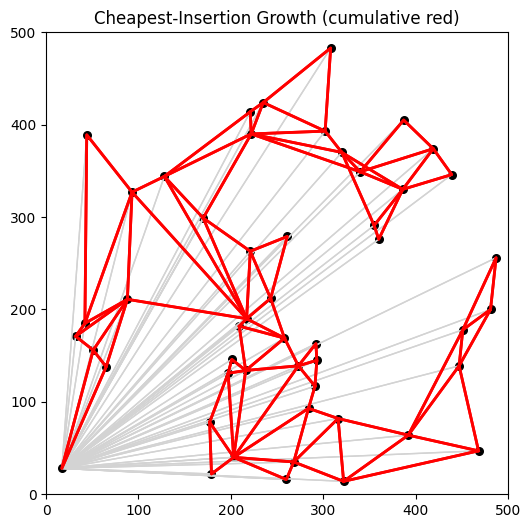

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 1) Build per‑step candidate *edge* segments and the chosen segment
all_cand_segs, chosen_segs = [], []
for tour_before, step_cands, best_idx in cheapest_history:
    step_segs = []
    for city, pos, cand, length in step_cands:
        # find endpoints in tour_before at insertion pos
        prev_city = tour_before[pos-1] if pos>0 else tour_before[-1]
        # wrap insertion at end → next = first city
        next_city = tour_before[pos] if pos < len(tour_before) else tour_before[0]
        # each seg is a 2‑point line from prev_city→city→next_city
        pts = np.vstack([ coords[prev_city], coords[city], coords[next_city] ])
        step_segs.append(pts)
    all_cand_segs.append(step_segs)
    
    # chosen one
    city, pos, cand, length = step_cands[best_idx]
    prev_city = tour_before[pos-1] if pos>0 else tour_before[-1]
    next_city = tour_before[pos] if pos < len(tour_before) else tour_before[0]
    chosen_segs.append(np.vstack([
        coords[prev_city],
        coords[city],
        coords[next_city]
    ]))

# 2) Set up the figure

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1], s=30, color="black")
ax.set(xlim=(0,500), ylim=(0,500), aspect="equal",
       title="Cheapest‑Insertion Growth (cumulative red)")

# gray spokes as before
max_cands = max(len(s) for s in all_cand_segs)
gray_lines = [ ax.plot([],[], lw=1, color="lightgray")[0]
               for _ in range(max_cands) ]

# **start with NO red lines** in the axes
red_lines: list[plt.Line2D] = []

def init():
    for ln in gray_lines:
        ln.set_data([],[])
    # leave red_lines untouched
    return gray_lines + red_lines

def update(i):
    # 1) update all gray candidate spokes for this step
    for ln, seg in zip(gray_lines, all_cand_segs[i]):
        ln.set_data(seg[:,0], seg[:,1])
    for ln in gray_lines[len(all_cand_segs[i]):]:
        ln.set_data([],[])

    # 2) draw *one new* red line for this chosen segment,
    #    but DO NOT clear the previous ones
    seg = chosen_segs[i]
    new_red, = ax.plot(seg[:,0], seg[:,1], lw=2, color="red")
    red_lines.append(new_red)

    # return all artists (gray + all reds so far)
    return gray_lines + red_lines

ani = animation.FuncAnimation(
    fig, update,
    frames=len(cheapest_history),
    init_func=init,
    interval=200,
    blit=True,
    repeat=False
)

HTML(ani.to_jshtml())
# save out the GIF
ani.save("cheapest_growth.gif", writer="pillow", fps=5)

